# "COVID-19: Your State is Not That Different"
> "All 50 US States and Washington DC saw exponential growth in confirmed cases, and have not shown clear signs of slowing down."

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [covid]
<!-- - image: images/test.png -->
- hide: false

In [1]:
#hide
library(tidyverse)
library(lubridate)
library(janitor)

theme_set(theme_light(base_size = 20))


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test




This post is inspired by the following work:

* The smoothed [log-log plot](https://aatishb.com/covidtrends/) of cumulative cases against new cases, by [Aatish Bhatia](https://aatishb.com/) and [Minute Physics](https://www.youtube.com/watch?v=54XLXg4fYsc). The log-log scale and the stock vs (smoothed 7-day) flow help us to see the exponential path each country was on, and make it easier to spot when the growth has passed the exponential growth phase and started to slow down.
* Kieran Healy's [replication](https://kieranhealy.org/blog/archives/2020/03/27/a-covid-small-multiple/) of John Burn-Murdoch's [small-multiple plot](https://www.ft.com/coronavirus-latest) of confirmed cases by country. The technique is useful to contrast a country's trajectory with other countries trajectories, putting things into perspective.

I combine these two approaches to show that all 50 States and Washington DC in the United States saw exponential growth in confirmed cases, and have not shown clear signs of slowing down, with some caveats below.


In [2]:
#hide
fixed_date = lubridate::date("2020-03-28")
us_states_raw <- read_csv("https://covidtracking.com/api/states/daily.csv") %>%
        janitor::clean_names()
us_states <- us_states_raw %>%
    select(date, state, positive, negative, pending, death, test = total_test_results) %>%
    mutate(date = lubridate::ymd(date)) %>%
    # filter(date <= lubridate::today() - 1) %>%
    filter(date <= fixed_date) %>%
    pivot_longer(positive:test, names_to = "measure", values_to = "count")


── Column specification ────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  state = col_character(),
  totalTestResultsSource = col_character(),
  dataQualityGrade = col_character(),
  lastUpdateEt = col_character(),
  dateModified = col_datetime(format = ""),
  checkTimeEt = col_character(),
  dateChecked = col_datetime(format = ""),
  fips = col_character(),
  hash = col_character(),
  grade = col_logical()
)
ℹ Use `spec()` for the full column specifications.




In [3]:
#hide
state_name <- read_csv('
    "sname","state"
    "Alabama","AL"
    "Alaska","AK"
    "Arizona","AZ"
    "Arkansas","AR"
    "California","CA"
    "Colorado","CO"
    "Connecticut","CT"
    "Delaware","DE"
    "D.C.","DC"
    "Florida","FL"
    "Georgia","GA"
    "Hawaii","HI"
    "Idaho","ID"
    "Illinois","IL"
    "Indiana","IN"
    "Iowa","IA"
    "Kansas","KS"
    "Kentucky","KY"
    "Louisiana","LA"
    "Maine","ME"
    "Montana","MT"
    "Nebraska","NE"
    "Nevada","NV"
    "New Hampshire","NH"
    "New Jersey","NJ"
    "New Mexico","NM"
    "New York","NY"
    "North Carolina","NC"
    "North Dakota","ND"
    "Ohio","OH"
    "Oklahoma","OK"
    "Oregon","OR"
    "Maryland","MD"
    "Massachusetts","MA"
    "Michigan","MI"
    "Minnesota","MN"
    "Mississippi","MS"
    "Missouri","MO"
    "Pennsylvania","PA"
    "Rhode Island","RI"
    "South Carolina","SC"
    "South Dakota","SD"
    "Tennessee","TN"
    "Texas","TX"
    "Utah","UT"
    "Vermont","VT"
    "Virginia","VA"
    "Washington","WA"
    "West Virginia","WV"
    "Wisconsin","WI"
    "Wyoming","WY"
')

states_gt100 <-
    us_states %>%
    filter(measure == "positive") %>%
    group_by(state) %>%
    filter(date == max(date)) %>%
    filter(count >= 100) %>%
    pull(state)

states_cumulative <- 
    us_states %>%
    inner_join(state_name, by = "state") %>%
    filter(measure == "positive") %>%
    select(state, sname, date, count) %>%
    group_by(state) %>%
    mutate(
        increase_7d = count - lag(count, 7, order_by = date),
        increase_4d = count - lag(count, 4, order_by = date),
        increase_1d = count - lag(count, 1, order_by = date),
    ) %>%
    ungroup()

all_states_background <-
    states_cumulative %>%
    select(st = state, date, count, starts_with("increase_"))
    
endpoints <-
    states_cumulative %>%
    group_by(state) %>%
    filter(date == max(date)) %>%
    ungroup()

state_name_label <- 
    states_cumulative %>%
    group_by(state) %>%
    filter(date == max(date)) %>%
    ungroup() %>%
    mutate(
        count = 1, 
        increase_7d = max(increase_7d, na.rm = T) - 1e4,
        increase_4d = max(increase_4d, na.rm = T) - 1e4,
        increase_1d = max(increase_1d, na.rm = T) - 1e4,
    ) %>%
    select(state, sname, count, starts_with("increase_"))

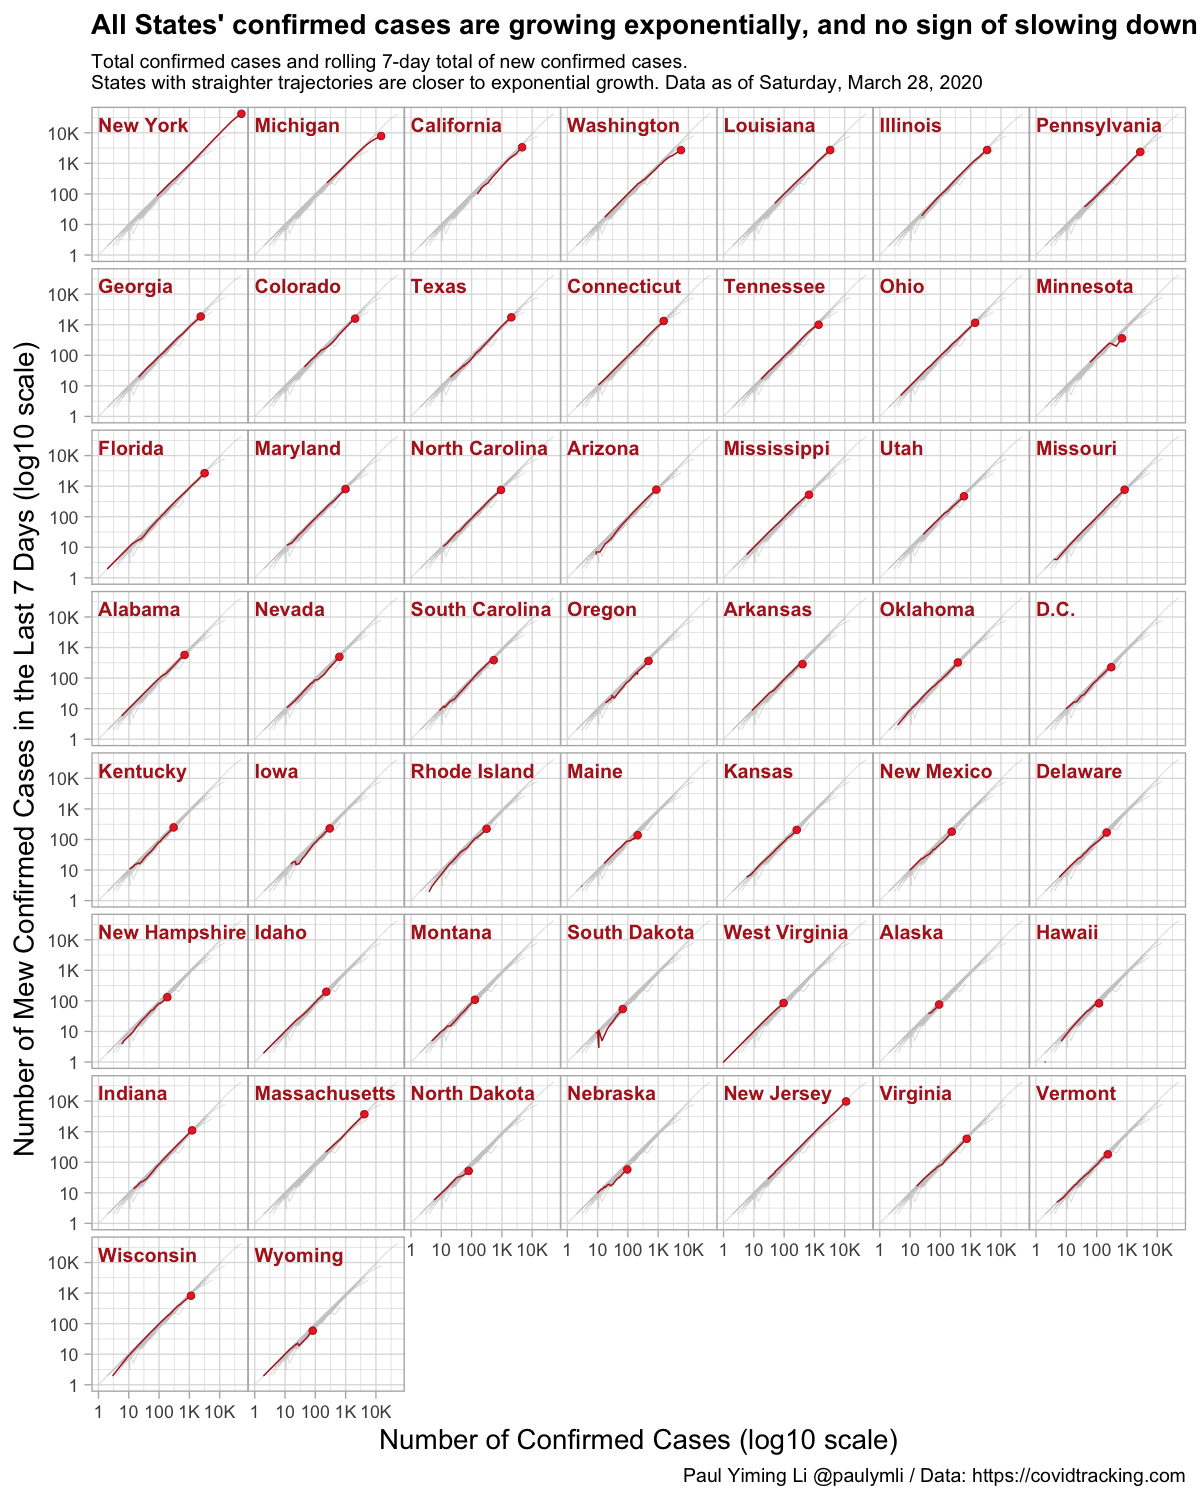

In [9]:
#hide_input
options(repr.plot.width = 12, repr.plot.height = 15, repr.plot.res = 100)
plt = states_cumulative %>%
    ggplot(mapping = aes(x = count, y = increase_7d)) + 
    # The line traces for every country, in every panel
    geom_line(data = all_states_background, 
              aes(group = st),
              size = 0.2, color = "gray80") + 
    # The line trace in red, for the country in any given panel
    geom_line(color = "firebrick",
              lineend = "round") + 
    # The point at the end. Bonus trick: some points can have fills!
    geom_point(data = endpoints, 
               size = 2.2, 
               shape = 21, 
               color = "firebrick",
               fill = "firebrick2"
    ) + 
    # The country label inside the panel, in lieu of the strip label
    geom_text(data = state_name_label,
              mapping = aes(label = sname),
              vjust = "inward",
              hjust = "inward",
              fontface = "bold",
              color = "firebrick",
              size = 5) +
    # Log transform and friendly labels
    scale_x_log10(labels = scales::label_number_si()) + 
    scale_y_log10(labels = scales::label_number_si()) + 
    # Facet by country, order from high to low
    facet_wrap(~ reorder(state, -count), ncol = 7) + 
    labs(x = "Number of Confirmed Cases (log10 scale)",
         y = "Number of Mew Confirmed Cases in the Last 7 Days (log10 scale)",
         title = "All States' confirmed cases are growing exponentially, and no sign of slowing down",
         # title = "Exponential Growth of COVID-19 Confirmed Cases by US State",
         subtitle = paste("Total confirmed cases and rolling 7-day total of new confirmed cases.\nStates with straighter trajectories are closer to exponential growth.", "Data as of", format(max(us_states$date), "%A, %B %e, %Y")),
         caption = "Paul Yiming Li @paulymli / Data: https://covidtracking.com") +
    theme(plot.title = element_text(size = rel(1), face = "bold"),
          plot.subtitle = element_text(size = rel(0.7)),
          plot.caption = element_text(size = rel(0.7)),
          # turn off the strip label and tighten the panel spacing
          strip.text = element_blank(),
          panel.spacing.x = unit(-0.05, "lines"),
          panel.spacing.y = unit(0.3, "lines"),
          axis.text.x = element_text(size = rel(0.8)),
          axis.text.y = element_text(size = rel(0.8)),
          axis.title.x = element_text(size = rel(1)),
          axis.title.y = element_text(size = rel(1)),
          legend.text = element_text(size = rel(1)))

suppressWarnings(print(plt))

A few notes to help with the interpretation of the graph:

* X axis is the cumulative number of confirmed cases in log10 scale, and the y axis is the new confirmed cases in the last 7 days in log10 scale.
* Each day corresponds to a point on each of the graphs. Imaging a dot climbing up to the top right corner of each graph, with the large red dot representing the latest day, leaving a trace behind it.
* The gray background lines of each small-multiple panel are the growth paths of all other states.
* The 7-day period in the y axis is to smooth the daily fluctuations in new confirmed cases.
* If the growth of confirmed cases are exponential, the slope of log(confirmed cases) vs log(total new cases in the last 7 days) is 45 degrees. Therefore the fact that every state is on the 45-degree line suggests every state is on an exponential growth path.
* But the 45-degree line does not suggest all states share the same rate of growth, just that all states are on some exponential path.
* This graph only considers confirmed/detected cases, not the actually infected cases, which are only larger than detected cases. Limited testing is likely an important factor that confounds the interpretation: the actual spread of the virus could be faster or slower than the increase in confirmed cases. Combining confirmed cases and hospitalizations trends may help paint a clearer picture. Although a shorter time series, the hospitalization trends are also exponential in states that report the data.
* The chart is not intended to be predictive: it's tracking the smoothed trends to see where we are, not where we are going to be. Specifically, it's tracking whether or not the confirmed cases are still on an exponential growth trajectory.